In [145]:
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
RANDOM_SEED = 6 
pd.set_option("display.max_columns", 100)

In [146]:
features_df = pd.read_csv("training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv("training_set_labels.csv", 
    index_col="respondent_id"
)

In [147]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

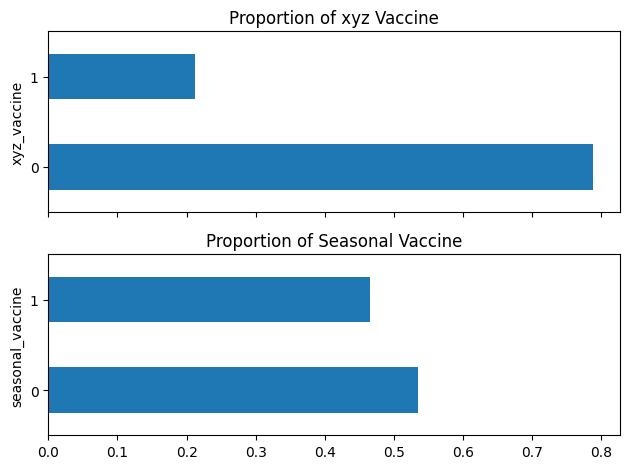

In [148]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_df.shape[0]

(labels_df['xyz_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of xyz Vaccine", ax=ax[0])
)
ax[0].set_ylabel("xyz_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [149]:
pd.crosstab(
    labels_df["xyz_vaccine"], 
    labels_df["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
xyz_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [150]:
(labels_df["xyz_vaccine"]
     .corr(labels_df["seasonal_vaccine"], method="pearson")
)

0.37714265306144684

In [151]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [152]:
counts = (joined_df[['xyz_concern', 'xyz_vaccine']]
              .groupby(['xyz_concern', 'xyz_vaccine'])
              .size()
              .unstack('xyz_vaccine')
         )
counts

xyz_vaccine,0,1
xyz_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


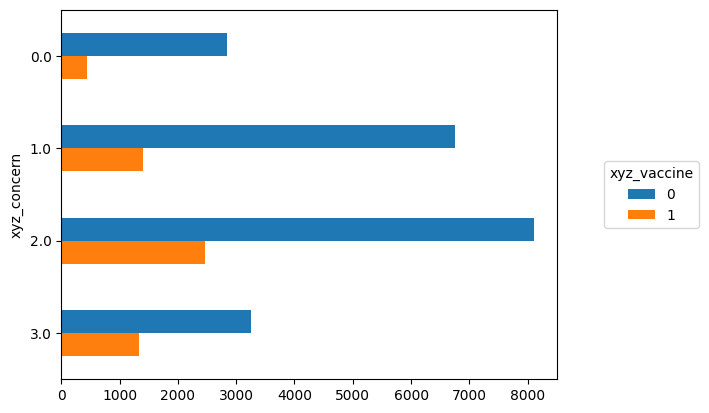

In [153]:
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='xyz_vaccine'
)

In [154]:
xyz_concern_counts = counts.sum(axis='columns')
xyz_concern_counts

xyz_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [155]:
props = counts.div(xyz_concern_counts, axis='index')
props

xyz_vaccine,0,1
xyz_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


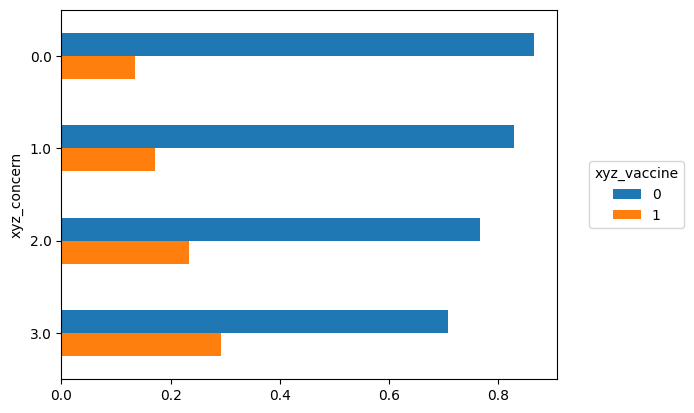

In [156]:
ax = props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='xyz_vaccine'
)

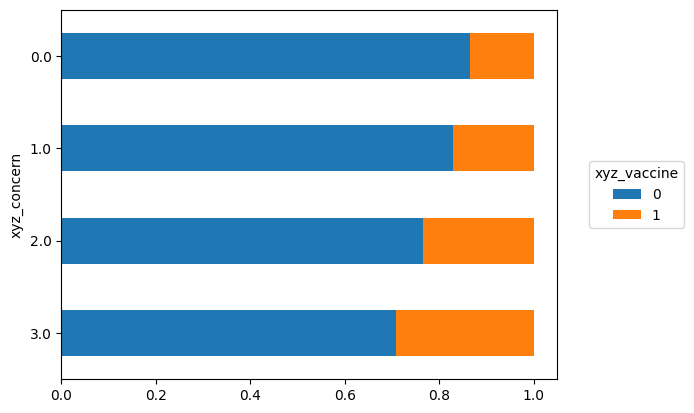

In [157]:
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='xyz_vaccine'
)

In [158]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

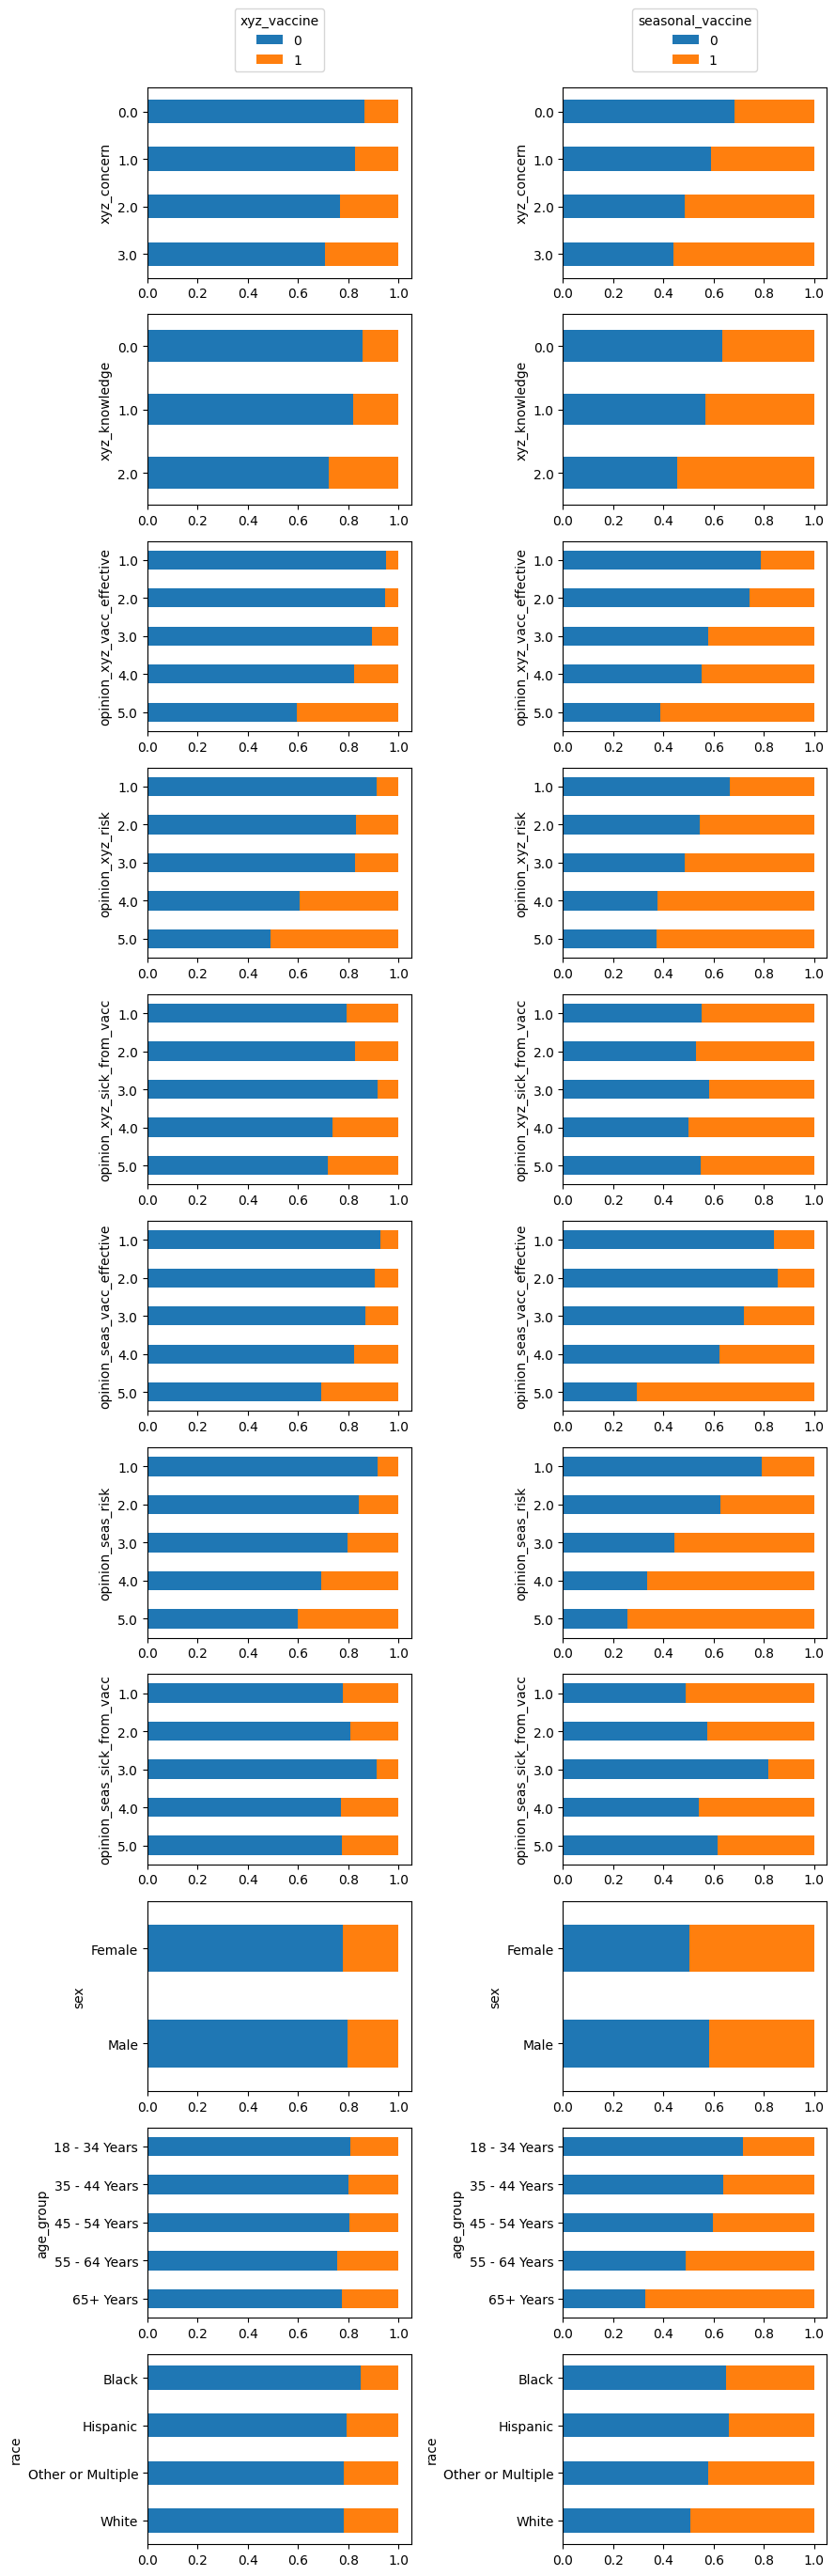

In [159]:
cols_to_plot = [
    'xyz_concern',
    'xyz_knowledge',
    'opinion_xyz_vacc_effective',
    'opinion_xyz_risk',
    'opinion_xyz_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'xyz_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='xyz_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

In [160]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['xyz_concern' 'xyz_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_xyz' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_xyz_vacc_effective' 'opinion_xyz_risk'
 'opinion_xyz_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [161]:
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [162]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)

In [163]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [164]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [165]:
%%time
full_pipeline.fit(X_train, y_train)
preds = full_pipeline.predict_proba(X_eval)
preds

CPU times: total: 62.5 ms
Wall time: 259 ms


[array([[0.70899902, 0.29100098],
        [0.90223299, 0.09776701],
        [0.84460779, 0.15539221],
        ...,
        [0.92338183, 0.07661817],
        [0.89634199, 0.10365801],
        [0.92791534, 0.07208466]]),
 array([[0.52722326, 0.47277674],
        [0.61834416, 0.38165584],
        [0.36997642, 0.63002358],
        ...,
        [0.85935471, 0.14064529],
        [0.77834996, 0.22165004],
        [0.15113572, 0.84886428]])]

In [166]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


In [170]:
y_preds = pd.DataFrame(
    {
        "xyz_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,xyz_vaccine,seasonal_vaccine
respondent_id,,
6728,0.291001,0.472777
16516,0.097767,0.381656
3106,0.155392,0.630024
16981,0.661595,0.857878
19111,0.284395,0.776941


In [171]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

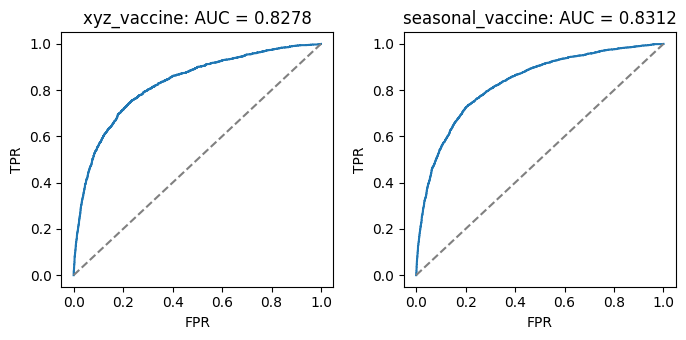

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['xyz_vaccine'], 
    y_preds['xyz_vaccine'], 
    'xyz_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [173]:
roc_auc_score(y_eval, y_preds)

0.8294727455824251

In [174]:
%%time 

full_pipeline.fit(features_df, labels_df)

None 

CPU times: total: 78.1 ms
Wall time: 226 ms


In [175]:
test_features_df = pd.read_csv("test_set_features.csv", 
                               index_col="respondent_id")

In [176]:
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.87283819, 0.12716181],
        [0.94481184, 0.05518816],
        [0.62897566, 0.37102434],
        ...,
        [0.93586025, 0.06413975],
        [0.80407916, 0.19592084],
        [0.94923908, 0.05076092]]),
 array([[0.57376944, 0.42623056],
        [0.92878998, 0.07121002],
        [0.3625742 , 0.6374258 ],
        ...,
        [0.75982876, 0.24017124],
        [0.59853519, 0.40146481],
        [0.67993994, 0.32006006]])]

In [178]:
submission_df = pd.read_csv("submission.csv", 
                            index_col="respondent_id")

In [179]:
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
submission_df["xyz_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,xyz_vaccine,seasonal_vaccine
respondent_id,,
26707,0.127162,0.426231
26708,0.055188,0.071210
26709,0.371024,0.637426
26710,0.464154,0.803612
26711,0.286619,0.634788


In [180]:
submission_df.to_csv('submission.csv', index=True)